# Trail Camera Image and Video Search with Meta AI ImageBind
This project demonstrates how to build multi-modal search (image and video) using the [Meta AI ImageBind](https://videobind.metademolab.com/) and [Weaviate](https://weaviate.io/) vector database.

## Weaviate Setup

The ImageBind model is only available with local Weaviate deployments with Docker or Kubernetes.

ImageBind is not supported with Weaviate Cloud Services (WCS).

### Steps to deploy Weaviate locally with ImageBind

1. Install Docker.
    
   > If you are new to `Docker Compose`, [here are instructions on how to install it](https://docs.docker.com/compose/install/).

2. Run Weaviate+Bind with Docker Compose

     In the terminal, navigate to the root director of this project and locate the file `docker-compose.yml` and call:

    ```
    docker compose up
    ```
    
    > Note #1 - the first time you run the command, Docker will download a ~6GB image.
  
    > Note #2 – running this Docker image requires 12GB of RAM.  If you're in Windows you'll need to adjust your .wslconfig to include the following:

    ```
    [wsl2]
    memory=12GB
    ```

### Dependencies

Install the Weaviate client library for Python.

In [1]:
%pip install weaviate-client

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: weaviate-client in c:\python312\lib\site-packages (3.25.2)




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Configuration

Verify the Weaviate client can connect to the local Weaviate server.



In [4]:
import weaviate
import os

# Connect to Weaviate
client = weaviate.Client(
  url="http://localhost:8080",  # URL to your local Weaviate instance
)

client.is_ready() # Test the connection

True

### Create `Media` collection

The collection has the following key characteristics:
1. Class: `"Media"`
2. Vectorizer: `multi2vec-bind`
3. Image property: `"img"` - Weaviate will use values in "img" property to generate vectors. Note, you can call it anything you want.

In [8]:
# Delete the collection if it exists.
# Note you should skip this step if you don't want to reimport the data every time.
if client.schema.exists("Media"):
    client.schema.delete_class("Media")

media = {
    "classes": [
        {
            "class": "Media",            
            "vectorizer": "multi2vec-bind",            
            "moduleConfig": {
                "multi2vec-bind": {
                    "imageFields": ["image"],
                    "videoFields": ["video"],
                }
            },
            "properties": [
                {
                    "dataType": ["blob"],
                    "name": "image"
                },
                {
                    "dataType": ["blob"],
                    "name": "video"
                }
            ]
        }
    ]
}

client.schema.create(media)
print("Successfully created Media collection.")

Successfully created Media collection.


### Import Media
For every object, we will store:
* `name` - the file name 
* `path` - path to the file, so that we could display returned images at query time.
* (one of the following) media:
    * `image` - a base64 representation of the image file, Weaviate will use it to generate a vector - see `imageFields`.
    * `video` - a base64 representation of the video file, Weaviate will use it to generate a vector - see `videoFields`.


In [4]:

import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

#### Import images

Import all of our training images

In [9]:
import glob
import os

# Fetch all jpg images in the directory
image_directory = "../assets/train/images/"
image_files = glob.glob(os.path.join(image_directory, '*.jpg'))  # Add more patterns if needed like '*.jpg'

client.batch.configure(batch_size=5)  # Load images in batches of 5
with client.batch as batch:
    for image_path in image_files:
        image_name = os.path.basename(image_path)  # Extracts the file name from the path
        print(f"Adding {image_name}")

        # Object to store in Weaviate
        properties = {
            "name": image_name,
            "path": image_path,
            "image": toBase64(image_path), # Weaviate will use the base64 representation of the file to generate a vector.
            "mediaType": "image"
        }

        # Add the object to Weaviate
        client.batch.add_data_object(properties, "Media")

Adding 01d5d81b-bd5e-4b24-8080-88c842ea9c65.jpg
Adding 091c241c-24a8-4e84-bbc4-7bde4b231020.jpg
Adding 0988e6e7-2048-4759-8bcf-c27a83141753.jpg
Adding 09e98f94-eb55-4bca-9b47-e3107bac82a2.jpg
Adding 1761315a-51d9-40be-b7a8-71d4a06a0fa8.jpg
Adding 1bc6c418-85b2-4eee-b4ea-d1934bfbde2f.jpg
Adding 23fc85c9-2779-4c0d-a99e-0c2de5d80187.jpg
Adding 331ec4cd-b8eb-4129-a706-6d54f996e6b3.jpg
Adding 3959813e-e673-4a89-b7f9-7a5aaec7db26.jpg
Adding 3ecb44b2-5905-4ab5-aa5d-1369ed0e6144.jpg
Adding 414b89a3-c8bc-4459-8eaf-2230529571f4.jpg
Adding 5176580c-0fd0-4d02-b3c6-e13d2b67f6bb.jpg
Adding 54029f49-0d72-47c9-966d-e3f349c8cf12.jpg
Adding 54d5f35a-33c7-4eb4-8593-faf12a4f2260.jpg
Adding 58690eaa-12e2-413e-ad8f-ebe5304d3f8b.jpg
Adding 7b589ddf-1fda-4262-8883-ede7cc9b1cd2.jpg
Adding 7bee66a7-562b-4f06-a759-3652e0d4d923.jpg
Adding 884f315c-ceec-46d8-86b0-d3035b397bb4.jpg
Adding 8b209d7b-6c29-49d3-88ad-e28fbfa0c616.jpg
Adding 930a9af8-45ed-4acf-b0c5-3aa0e39c0c1b.jpg
Adding 96f6b1ed-5f7c-4bb7-90b0-662dd7db3

#### Import Video

Import all of our training videos

In [ ]:
import glob
import os

# Fetch all mp4 videos in the directory
video_directory = "../assets/train/videos/"
video_files = glob.glob(os.path.join(video_directory, '*.mp4'))  # Add more patterns if needed like '*.mp4'

client.batch.configure(batch_size=1)  # Load videos in batches of 1 as these might be big files
with client.batch as batch:
    for video_path in video_files:
        video_name = os.path.basename(video_path)  # Extracts the file name from the path
        print(f"Adding {video_name}")

        # Object to store in Weaviate
        properties = {
            "name": video_name,
            "path": video_path,
            "video": toBase64(video_path), # Weaviate will use the base64 representation of the file to generate a vector.
            "mediaType": "video"
        }

        # Add the object to Weaviate
        client.batch.add_data_object(properties, "Media")

### Check number of objects in the Media collection

In [5]:
# Display the number of objects in the Media collection
client.query.aggregate("Media").with_meta_count().do()

{'data': {'Aggregate': {'Media': [{'meta': {'count': 35}}]}}}

## Query examples

In [6]:
# Helper functions to display results
import json
from IPython.display import Image, Video

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path))

    elif(item["mediaType"] == "video"):
        display(Video(path))

### Text to Media search

Search for media using a text search

In [10]:
def text_search(query, results):
    # Validate the 'results' parameter
    if not isinstance(results, int) or results <= 0:
        raise ValueError("The 'results' parameter must be a positive integer.")

    try:
        response = (
            client.query
            .get("Media", "name path mediaType")
            .with_near_text({"concepts": query})
            .with_limit(results)
            .do()
        )

        # Extract the result
        result = response["data"]["Get"]["Media"]

        if not result:
            print("No results found.")
            return

        # Print the results in JSON format
        json_print(result)

        # Display the specified number of results
        for media in result[:results]:
            display_media(media)

    except Exception as e:
        print(f"An error occurred: {e}")

[
  {
    "mediaType": "image",
    "name": "ac17a53f-f12a-41ed-890c-1d794bd19a29.jpg",
    "path": "../assets/train/images\\ac17a53f-f12a-41ed-890c-1d794bd19a29.jpg"
  },
  {
    "mediaType": "image",
    "name": "e4e1cd0c-ea06-4cdf-ae52-a7b31aaaff00.jpg",
    "path": "../assets/train/images\\e4e1cd0c-ea06-4cdf-ae52-a7b31aaaff00.jpg"
  },
  {
    "mediaType": "image",
    "name": "01d5d81b-bd5e-4b24-8080-88c842ea9c65.jpg",
    "path": "../assets/train/images\\01d5d81b-bd5e-4b24-8080-88c842ea9c65.jpg"
  }
]


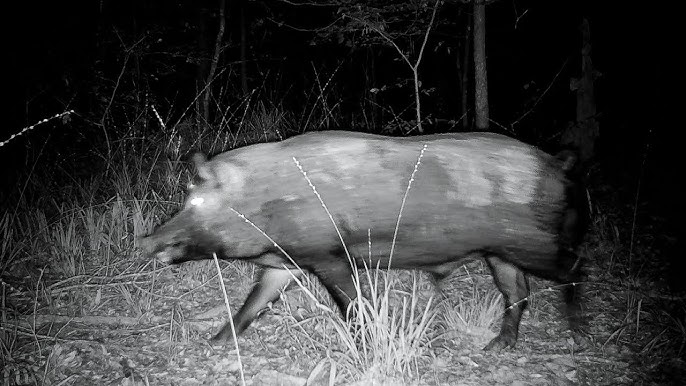

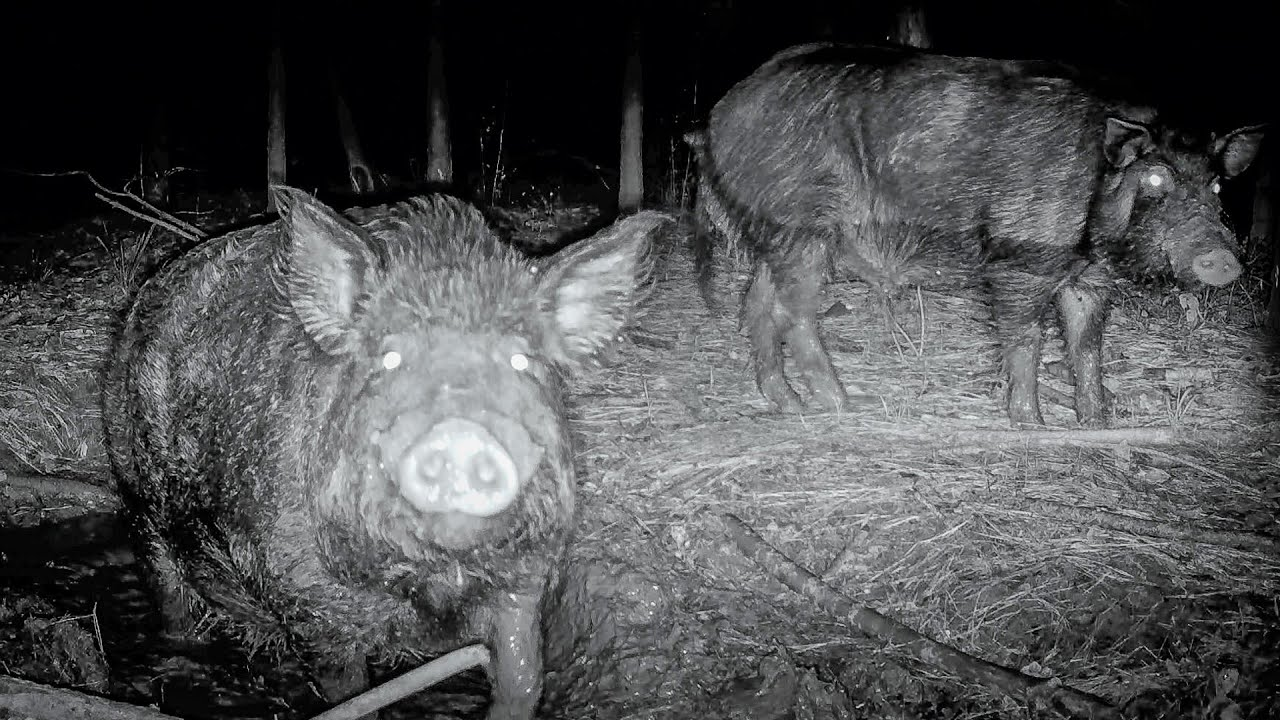

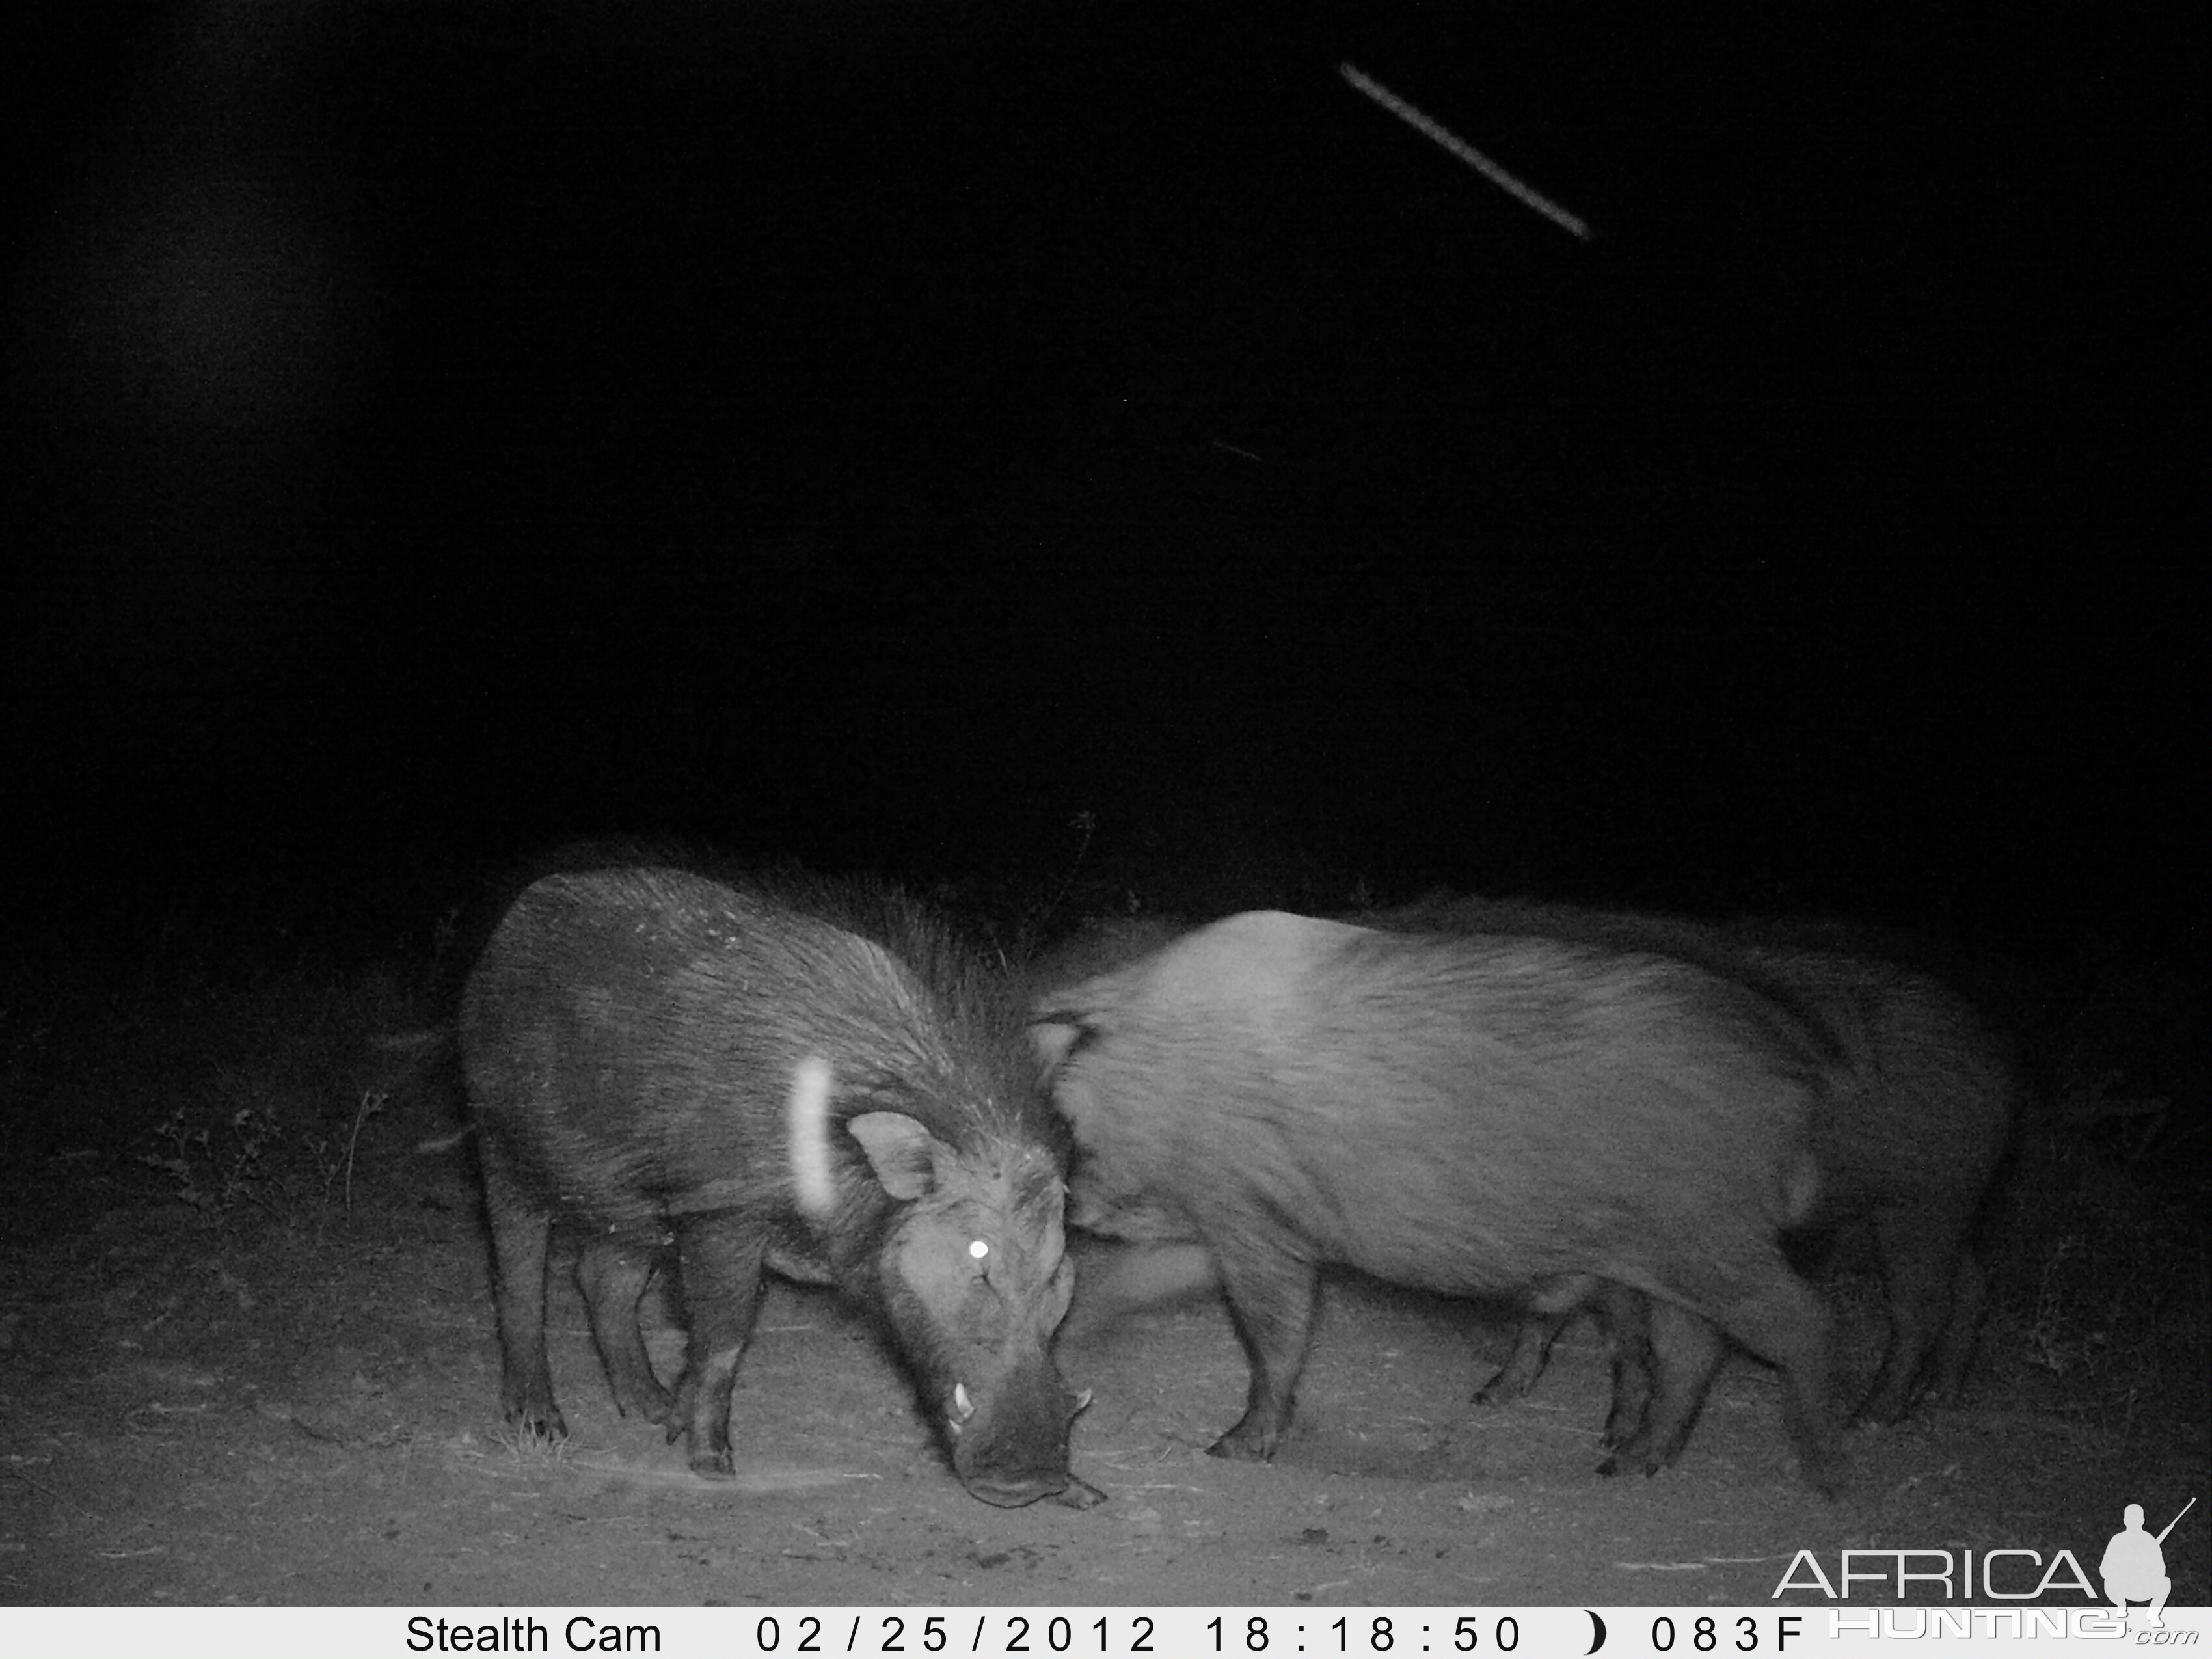

In [11]:
text_search('pig', 3)

### Image to Media search

In [ ]:
Image('test/test-cat.jpg')

In [ ]:
# Search for images that are similar to the provided image of test-meerkat, test-dog, test-cat
response = (
    client.query
    .get("Media", "name path mediaType")
    .with_near_image(
        # {"image": "./test/test-meerkat.jpg"}, # Use file path as the input for the query
        # {"image": "./test/test-dog.jpg"}, # Use file path as the input for the query
        {"image": "./test/test-cat.jpg"}, # Use file path as the input for the query
    )
    .with_limit(5)
    .do()
)

# Print results
result = response["data"]["Get"]["Media"]
json_print(result)

# Display the first image
display_media(result[0])

### Video to Media search

In [ ]:
Video('test/test-meerkat.mp4')

In [ ]:
# Search for images that are similar to the provided image of test-meerkat, test-dog, test-cat
response = (
    client.query
    .get("Media", "name path mediaType")
    .with_near_video(
        # {"video": "./test/test-dog.mp4"}, # Use file path as the input for the query
        # {"video": "./test/test-cat.mp4"}, # Use file path as the input for the query
        {"video": "./test/test-meerkat.mp4"}, # Use file path as the input for the query
    )
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Media"]
json_print(result)

# Display the first image
display_media(result[0])